# Faculty base in few Indian Institutes
> Lets' visualize

- toc: False 
- comments: true

# About

Step 1: I collected the NIRF 2021 data hosted by few institutes of our interest. Note that this is 2021 data, and as I understand this has been submitted to the Ministry of Education and hence, we can consider them authentic. The NIRF 2021 rankings are yet not released.

Thanks to the meticulous organization by few insitutes, I could easily download this data from the institute websites. We will focus on 13 institutes. These are:
* Indian Institute of Science (iisc)
* IIT Bombay (iit_bomb), IIT Kharagpur (iit_kgp), IIT Madras (iit_mad), IIT Kanpur (iit_kan), IIT Delhi (iit_delhi), IIT Varansi (iit_bhu), IIT Roorkee (iit_roor)
* IIT Jodhpur (iit_jodhpur), IIT Indore (iit_ind), IIT Bhubaneswar (iit_bbs), IIT Mandi (iit_mandi), IIT Hyderabad (iit_hyd)

Step 2: I did little bit of coding (in python) exercise to extract data from the PDF documents collected in Step 1. This data extract step is critical as it helps to load the data into a plotting tool!

Step 3: Rest is just plotting (again, using python). 

Note: I will only analyze data of faculty at three levels, namely, Assistant, Associate, and Full Professor. Also, I have skipped the Institute Director (1 nos.) from the analysis. 

So, what do we see!

In [1]:
#collapse
import PyPDF2
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sns
import numpy as np
sns.set() # Use seaborn's default style to make attractive graphs
sns.set_style("white")
sns.set_style("ticks")
plt.rcParams.update({'font.size': 12})


# path to PDFs
path_nirf = '/Users/neeks/Desktop/Documents/work/code/python_codes/notebookCodes/institutes/data/nirf_pdfs/'

# some function defs
def get_curated_rows(pdfReader):
    # get faculty listing start page
    for i in range(pdfReader.numPages):
        pageObj = pdfReader.getPage(i)
        lines = pageObj.extractText()
        if 'Faculty Details' in lines:
#             print('yes')
            page_indx = i
            break

    all_rows = []
    for i in range(page_indx,pdfReader.numPages):
        pageObj = pdfReader.getPage(i)
        if i == page_indx:
            lines = pageObj.extractText().split('Association type')[1]
        else:
            lines = pageObj.extractText()

        line_breaks = ['Regular', 'Visiting', 'Other']
        temp = lines
        for text in line_breaks:
            temp = temp.replace(text,';')

        all_rows.extend(temp.split(';'))

    # remove contractual rows
    curated_rows = []
    for text in all_rows:
        if len(text) == 0:
            continue
        elif 'Adhoc' in text:
            temp = text.split('Adhoc /Contractual')
            if len(temp)>1:
                if 'Professor' in temp[-1]:
                    curated_rows.append(temp[-1])
        else:
            if 'Professor' in text:
                curated_rows.append(text)
        
    return curated_rows


def get_parsed_dict(curated_rows, code):
    # make dictionary
    keys = ['name','age','designation','gender','degree','months','joining_day',
            'joining_month','joining_year','institute']
    data_dict = {}
    for key in keys:
        data_dict[key] = []

    for text in curated_rows:

        # remove serial number
        for i in range(len(text)):
            if (i == 0) & (text[i]==' '):
                continue
            if not(text[i].isdigit()):
                break
        text = text[i:]

        # search name
        for i in range(len(text)):
            if text[i].isdigit():
                break
        data_dict['name'].append(text[:i])
        text = text[i:]

        # search age
        for i in range(len(text)):
            if not(text[i].isdigit()):
                break 
        data_dict['age'].append(int(text[:i]))
        text = text[i:]

        # search designation
        text = text.split('Professor')
        if len(text[0]) == 0:
            data_dict['designation'].append('Professor')
        else:
            data_dict['designation'].append(text[0])

        text = text[1]
        # search for gender, degree
        if 'Ph.D' in text:
            data_dict['gender'].append(text.split('Ph.D')[0])
            data_dict['degree'].append('Ph.D')
            text = text.split('Ph.D')[1]
        elif 'M.Tech' in text:
            data_dict['gender'].append(text.split('M.Tech')[0])
            data_dict['degree'].append('M.Tech')
            text = text.split('M.Tech')[1]
        elif 'Master of Design' in text:
            data_dict['gender'].append(text.split('Master of Design')[0])
            data_dict['degree'].append('M.Des')
            text = text.split('Master of Design')[1]
        elif 'PGID' in text:
            data_dict['gender'].append(text.split('PGID')[0])
            data_dict['degree'].append('PGID')
            text = text.split('PGID')[1]
        elif 'M.Sc.' in text:
            data_dict['gender'].append(text.split('M.Sc.')[0])
            data_dict['degree'].append('M.Sc.')
            text = text.split('M.Sc.')[1]
        elif 'MFA(Fine Arts)' in text:
            data_dict['gender'].append(text.split('MFA(Fine Arts)')[0])
            data_dict['degree'].append('MFA(Fine Arts)')
            text = text.split('MFA(Fine Arts)')[1]
        elif 'P.G.Diploma' in text:
            data_dict['gender'].append(text.split('P.G.Diploma')[0])
            data_dict['degree'].append('P.G.Diploma')
            text = text.split('P.G.Diploma')[1]
        elif 'M. Phil' in text:
            data_dict['gender'].append(text.split('M. Phil')[0])
            data_dict['degree'].append('M. Phil')
            text = text.split('M. Phil')[1]
        elif 'M.Arch.' in text:
            data_dict['gender'].append(text.split('M.Arch.')[0])
            data_dict['degree'].append('M.Arch.')
            text = text.split('M.Arch.')[1]

        # search months
        for i in range(len(text)):
            if (i == 0) & (text[i]==' '):
                continue
            if not(text[i].isdigit()):
                break
        data_dict['months'].append(int(text[:i]))
        text = text[i:]

        # joining date 
        for i in range(len(text)):
            if text[i].isdigit():
                break
        text = text[i:]
        data_dict['joining_day'].append(int(text.split('-')[0]))
        data_dict['joining_month'].append(int(text.split('-')[1]))
        data_dict['joining_year'].append(int(text.split('-')[2][:4]))
        data_dict['institute'].append(code)

    return data_dict

def get_admin_info(pdfReader, code):
    admin_data = {}
    keys = ['PhDs_full','PhDs_part', 'staff_salaries', 'institute']
    for key in keys:
        admin_data[key] = []

    # search for PhD details page
    for i in range(pdfReader.numPages):
        pageObj = pdfReader.getPage(i)
        lines = pageObj.extractText()
        if 'Ph.D Student Details' in lines:
            page_indx = i
            break
    pageObj = pdfReader.getPage(i)
    lines = pageObj.extractText()
    text = lines.split("Total StudentsFull Time")[1]
    # get PhD Full time count
    for i in range(len(text)):
        if (i == 0) & (text[i]==' '):
            continue
        if not(text[i].isdigit()):
            break

    admin_data['PhDs_full'].append(int(text[:i]))
    text = text[i:].split('Part Time')[1]
    # get PhD Part time count
    for i in range(len(text)):
        if (i == 0) & (text[i]==' '):
            continue
        if not(text[i].isdigit()):
            break
    admin_data['PhDs_part'].append(int(text[:i]))

    # search for salaries page
    for i in range(pdfReader.numPages):
        pageObj = pdfReader.getPage(i)
        lines = pageObj.extractText()
        if 'Salaries (Teaching and Non Teaching staff)' in lines:
            page_indx = i
            break

    pageObj = pdfReader.getPage(i)
    lines = pageObj.extractText()
    text = lines.split("Salaries (Teaching and Non Teaching staff)")[1]
    # get PhD Full time count
    for i in range(len(text)):
        if (i == 0) & (text[i]==' '):
            continue
        if not(text[i].isdigit()):
            break

    admin_data['staff_salaries'].append(int(text[:i]))
    admin_data['institute'].append(code)

    return admin_data


# main code starts here
institutes = ['iisc','iit_kgp','iit_bhu','iit_delhi','iit_mad','iit_bom','iit_kan','iit_roor',
              'iit_ind','iit_hyd','iit_mandi','iit_jodh','iit_bbs']
cnt = 0
for insitute in institutes:
    file_name = glob.glob(path_nirf+insitute+'*')[0]
    pdfFileObj = open(file_name, 'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    
    # get admmin df
    data = get_admin_info(pdfReader, insitute)
    df_admin_temp = pd.DataFrame.from_dict(data)
    if cnt == 0:
        df_admin = df_admin_temp.copy()
    else:
        df_admin = pd.concat([df_admin, df_admin_temp])
    
    # get faculty df
    rows = get_curated_rows(pdfReader)
    data = get_parsed_dict(rows, insitute)
    df_fac_temp = pd.DataFrame.from_dict(data)
    
    if cnt == 0:
        df_fac = df_fac_temp.copy()
    else:
        df_fac = pd.concat([df_fac, df_fac_temp])
    cnt = cnt+1

## How is the PhD Scholars count ... 

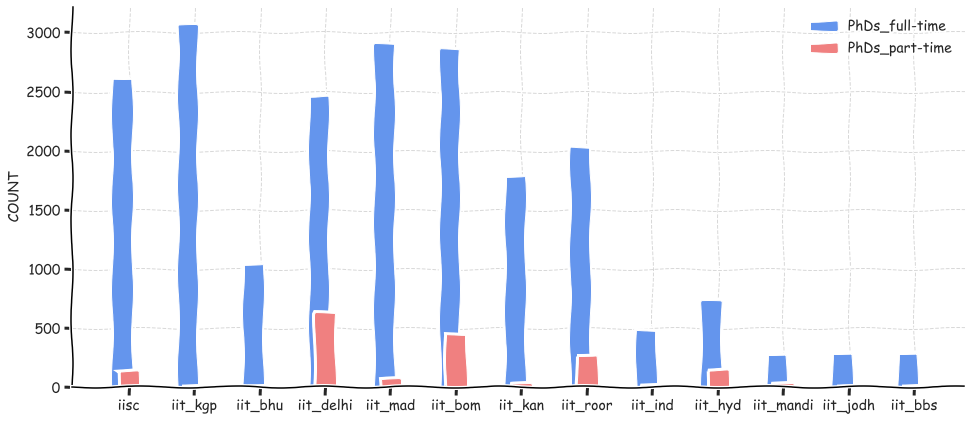

In [2]:
#collapse
# plot PhD count
data = {}
keys_1 = ['PhDs_full','PhDs_part']

        
with plt.xkcd():
    fig = plt.subplots(figsize=[16,7])
    ax = plt.subplot(1,1,1)
    FS = 14

    clr = ['cornflowerblue','lightcoral']
    for i in range(len(keys_1)):
        if i == 0:
            ax.bar(np.arange(len(institutes))+0.1*i,df_admin['PhDs_full'],width=0.3,color=clr[i],
                  label=keys_1[i]+str('-time'))
        else:
            ax.bar(np.arange(len(institutes))+0.1*i,df_admin['PhDs_part'],width=0.3,color=clr[i],
                  label=keys_1[i]+str('-time'))

    plt.xticks(np.arange(0,len(institutes))+.1,institutes,rotation=0, fontsize=FS)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.legend(frameon=False,fontsize=FS)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.set_ylabel('COUNT', fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()

## What about the salary expenses ...

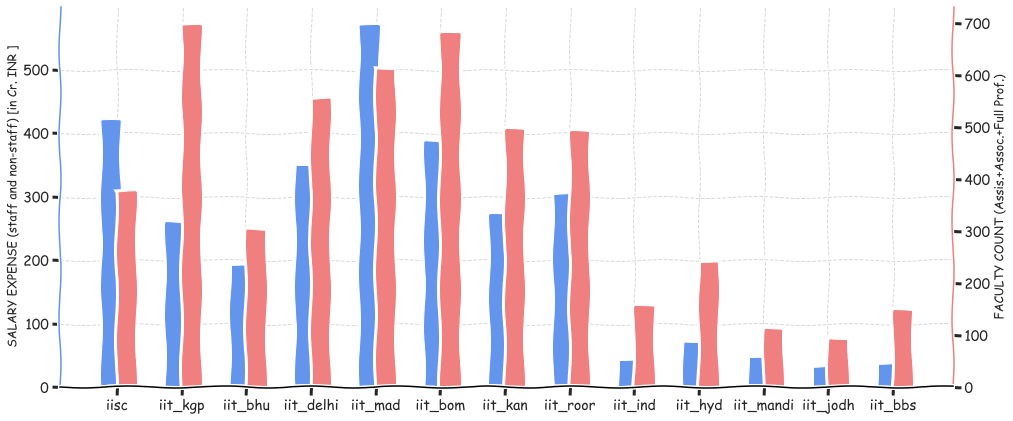

In [3]:
#collapse
# plot all salary exoense 
data = {}
keys_1 = ['staff_salaries']

val_fac_count = []
for institute in institutes:
    val_fac_count.append(len(df_fac[df_fac['institute']==institute]))
    
with plt.xkcd():
    fig = plt.subplots(figsize=[16,7])
    ax1 = plt.subplot(1,1,1)
    FS = 14

    clr = ['cornflowerblue','lightcoral']
    ax1.bar(np.arange(len(institutes)),df_admin['staff_salaries']/1e7,width=0.3,color=clr[0])
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax1.spines['top'].set_visible(False)  
    ax1.set_ylabel('SALARY EXPENSE (staff and non-staff) [in Cr. INR ]')
    ax1.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    
    ax2 = ax1.twinx()  
    ax2.bar(np.arange(len(institutes))+0.25,val_fac_count,width=0.3,color=clr[1])

    ax2.set_ylabel('FACULTY COUNT (Assis.+Assoc.+Full Prof.)')
    plt.xticks(np.arange(0,len(institutes))+.1,institutes,rotation=0, fontsize=FS)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax2.spines['top'].set_visible(False)  
    ax2.spines["right"].set_color(clr[1])
    ax2.spines["left"].set_color(clr[0])
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()

## How young (or old) are the Faculty ...

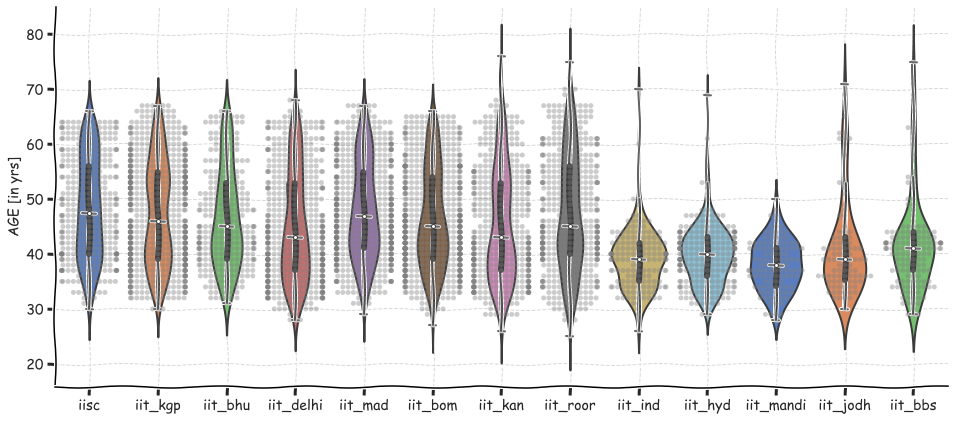

In [4]:
#collapse
# plot age (without gender)
df = df_fac.copy()
data = {}
keys = ['age','gender','designation']
for key in keys:
    data[key] = []
    
for institute in institutes:
    for key in keys:
        data[key].append(df[(df['institute']==institute)][key].values)

with plt.xkcd():
    fig = plt.subplots(figsize=[16,7])
    ax = plt.subplot(1,1,1)
    FS = 14

    sns.boxplot(data = data['age'], whis = np.inf,width = 0.2,color=(.3,.8,1))
    sns.swarmplot(data = data['age'], color='gray',alpha=0.4)
    sns.violinplot(data = data['age'], palette="muted")
    plt.xticks(np.arange(0,len(institutes)),institutes,rotation=0, fontsize=FS-2)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.set_ylabel('AGE [in yrs]', fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()


## age of Assistant Professors ... youngistaan!

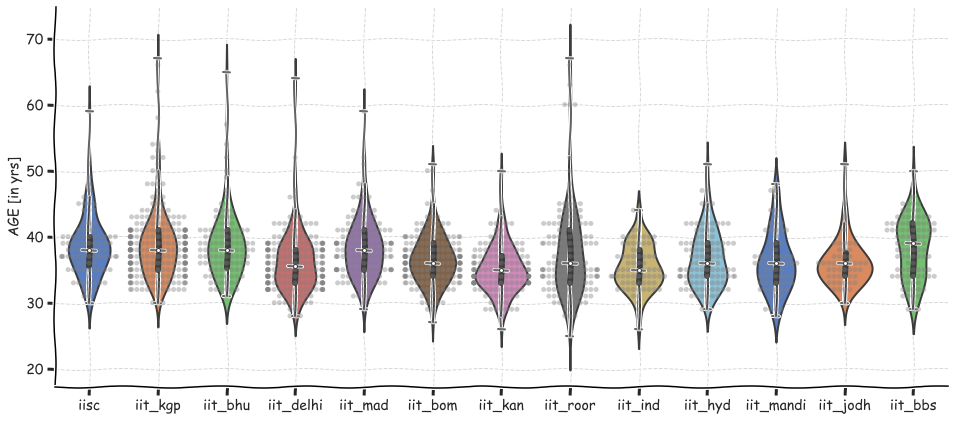

In [5]:
#collapse
# plot age (without gender)
data = {}
keys = ['age','gender','designation']
for key in keys:
    data[key] = []
    
for institute in institutes:
    for key in keys:
        data[key].append(df[(df['institute']==institute)&(df['designation']=='Assistant')][key].values)

with plt.xkcd():
    fig = plt.subplots(figsize=[16,7])
    ax = plt.subplot(1,1,1)
    FS = 14

    sns.boxplot(data = data['age'], whis = np.inf,width = 0.2,color=(.3,.8,1))
    sns.swarmplot(data = data['age'], color='gray',alpha=0.4)
    sns.violinplot(data = data['age'], palette="muted")
    plt.xticks(np.arange(0,len(institutes)),institutes,rotation=0, fontsize=FS-2)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.set_ylabel('AGE [in yrs]', fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()


## age of Associate Professors ...

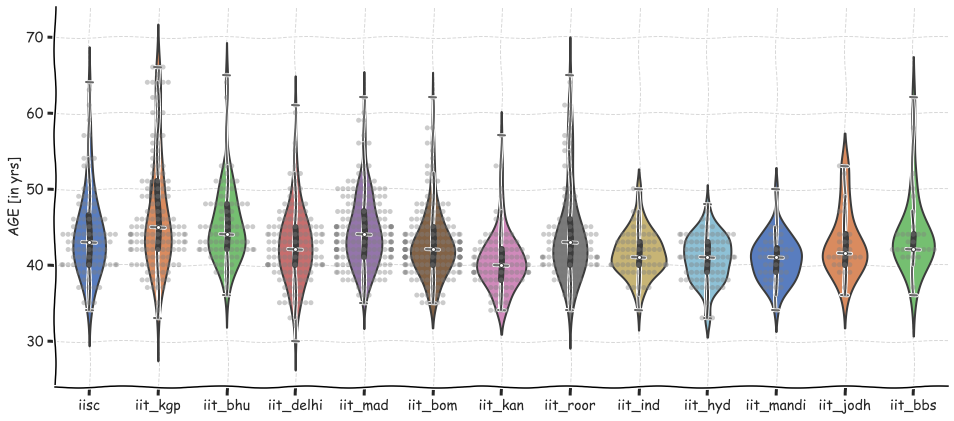

In [6]:
#collapse
# plot age (without gender)
data = {}
keys = ['age','gender','designation']
for key in keys:
    data[key] = []
    
for institute in institutes:
    for key in keys:
        data[key].append(df[(df['institute']==institute)&(df['designation']=='Associate')][key].values)

with plt.xkcd():
    fig = plt.subplots(figsize=[16,7])
    ax = plt.subplot(1,1,1)
    FS = 14

    sns.boxplot(data = data['age'], whis = np.inf,width = 0.2,color=(.3,.8,1))
    sns.swarmplot(data = data['age'], color='gray',alpha=0.4)
    sns.violinplot(data = data['age'], palette="muted")
    plt.xticks(np.arange(0,len(institutes)),institutes,rotation=0, fontsize=FS-2)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.set_ylabel('AGE [in yrs]', fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()



## and the age of (Legendary) Professors ...

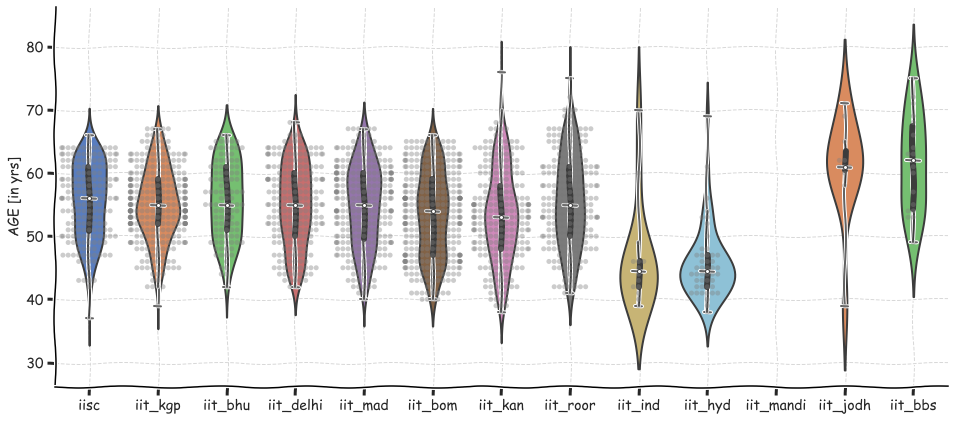

In [7]:
#collapse
# plot age (without gender)
data = {}
keys = ['age','gender','designation']
for key in keys:
    data[key] = []
    
for institute in institutes:
    for key in keys:
        data[key].append(df[(df['institute']==institute)&(df['designation']=='Professor')][key].values)

with plt.xkcd():
    fig = plt.subplots(figsize=[16,7])
    ax = plt.subplot(1,1,1)
    FS = 14

    sns.boxplot(data = data['age'], whis = np.inf,width = 0.2,color=(.3,.8,1))
    sns.swarmplot(data = data['age'], color='gray',alpha=0.4)
    sns.violinplot(data = data['age'], palette="muted")
    plt.xticks(np.arange(0,len(institutes)),institutes,rotation=0, fontsize=FS-2)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.set_ylabel('AGE [in yrs]', fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()



## Count of faculty across 3 designations ...

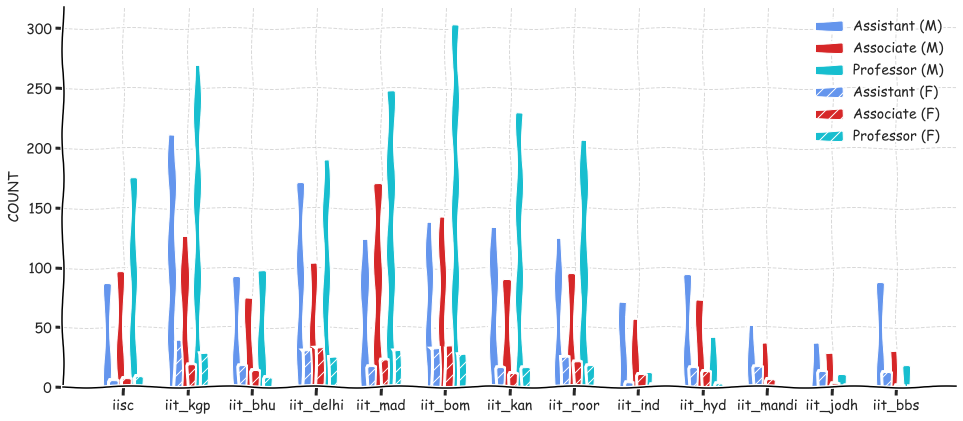

In [8]:
#collapse
# plot deisgnation (with gender)
data = {}
keys_1 = ['Male','Female']
keys_2 = ['Assistant','Associate','Professor']

for key_1 in keys_1:
    data[key_1] = {}
    for key_2 in keys_2:
        data[key_1][key_2] = []

for institute in institutes:
    for key_1 in keys_1:
        for key_2 in keys_2:
            data[key_1][key_2].append(len(df[(df['institute']==institute) &
                            (df['gender']==key_1) & (df['designation']==key_2)]))
        
with plt.xkcd():
    fig = plt.subplots(figsize=[16,7])
    ax = plt.subplot(1,1,1)
    FS = 14

    clr = ['cornflowerblue','tab:red','tab:cyan']
    for i in range(len(keys_1)):
        for j in range(len(keys_2)):
            if i == 0:
                ax.bar(np.arange(len(institutes))+0.1*i+0.2*j,data[keys_1[i]][keys_2[j]],width=0.1,color=clr[j],
                      label=keys_2[j]+str(' (M)'))
            else:
                ax.bar(np.arange(len(institutes))+0.1*i+0.2*j,data[keys_1[i]][keys_2[j]],width=0.1,color=clr[j],
                       hatch='//',label=keys_2[j]+str(' (F)'))

    plt.xticks(np.arange(0,len(institutes))+.25,institutes,rotation=0, fontsize=FS)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.legend(frameon=False,fontsize=FS)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.set_ylabel('COUNT', fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()

## How has been the faculty recuitment over time ...

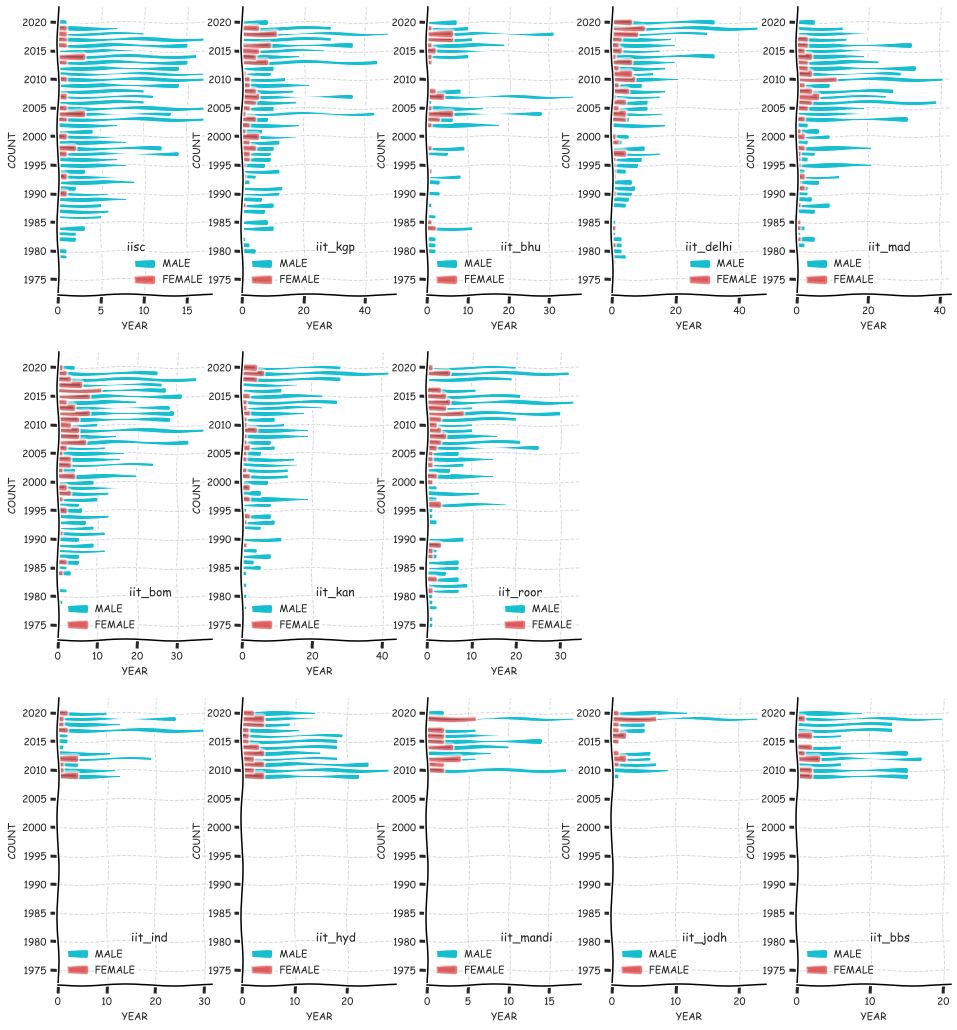

In [9]:
#collapse
# year of recruitment
x_grid = np.arange(min(df['joining_year']),max(df['joining_year'])+1)
y_grid = np.arange(0,len(institutes))

X, Y = np.meshgrid(x_grid, y_grid)
Z_m = np.zeros(X.shape)
Z_f = np.zeros(X.shape)

for i in range(len(institutes)):
    for j in range(len(x_grid)):
        Z_m[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_year']==x_grid[j])) & ((df['gender']=='Male'))])
        Z_f[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_year']==x_grid[j])) & ((df['gender']=='Female'))])        
clr = 'tab:cyan'
with plt.xkcd():
    fig = plt.figure(figsize=[16,18])
    FS = 10
    for i in range(Z_m.shape[0]):
            if i>7:
                ax = plt.subplot(3,5,i+3)
            else:
                ax = plt.subplot(3,5,i+1)
            ax.barh(x_grid,Z_m[i,:],alpha=1,label='MALE', height=0.65, color=clr)
            ax.barh(x_grid,Z_f[i,:],color='tab:red',alpha=0.5,label='FEMALE',height=0.75)
            plt.legend(frameon=False,loc='best', fontsize=FS)
            plt.yticks(x_grid[::5],x_grid[::5],rotation=0, fontsize=FS)
            ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
            plt.ylabel('COUNT',fontsize=FS)
            plt.xlabel('YEAR',fontsize=FS)
            plt.xticks(fontsize=FS)
            plt.yticks(fontsize=FS)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)  
            ax.text(max(Z_m[i,:]//2),1980,institutes[i],fontsize=FS+2)

    plt.show() 

## Which month do new faculty join?

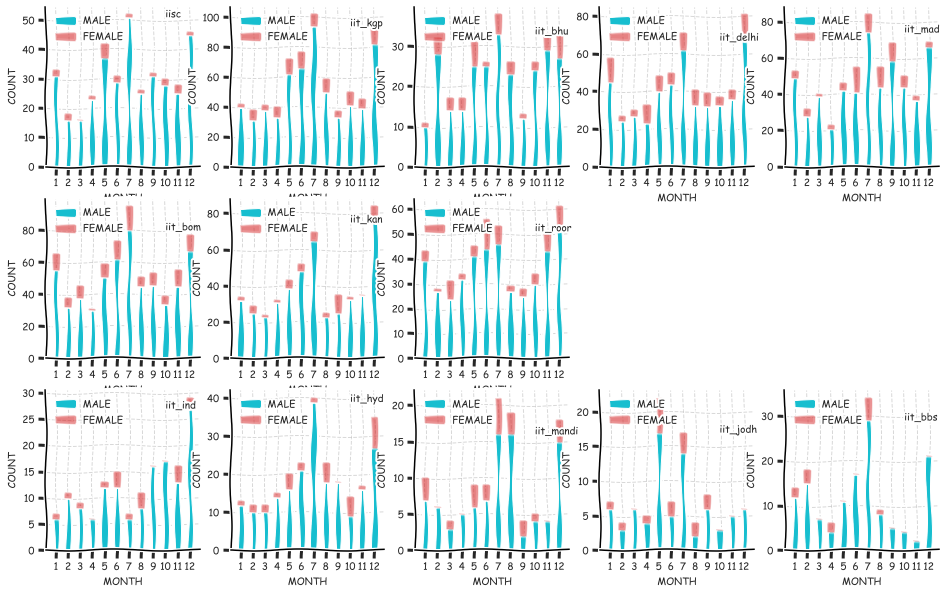

In [10]:
#collapse
# month of recruitment
x_grid = np.arange(min(df['joining_month']),max(df['joining_month'])+1)
y_grid = np.arange(0,len(institutes))

X, Y = np.meshgrid(x_grid, y_grid)
Z_m = np.zeros(X.shape)
Z_f = np.zeros(X.shape)

for i in range(len(institutes)):
    for j in range(len(x_grid)):
        Z_m[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_month']==x_grid[j])) & ((df['gender']=='Male'))])
        Z_f[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_month']==x_grid[j])) & ((df['gender']=='Female'))])        
with plt.xkcd():
    fig = plt.figure(figsize=[16,10])
    FS = 10
    clr = 'tab:cyan'
    for i in range(Z_m.shape[0]):
            if i>7:
                ax = plt.subplot(3,5,i+3)
            else:
                ax = plt.subplot(3,5,i+1)
            ax.bar(x_grid,Z_m[i,:],color=clr,alpha=1,width=0.35,label='MALE')
            ax.bar(x_grid,Z_f[i,:],bottom=Z_m[i,:],color='tab:red',alpha=0.35,width=0.5,label='FEMALE')
            plt.legend(frameon=False,loc='upper left', fontsize=FS)
            plt.xticks(x_grid,x_grid,rotation=0, fontsize=FS)
            ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
            plt.ylabel('COUNT',fontsize=FS)
            plt.xlabel('MONTH',fontsize=FS)

            plt.xticks(fontsize=FS)
            plt.yticks(fontsize=FS)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)  
            ax.text(10,max(Z_m[i,:]),institutes[i],fontsize=FS)
    plt.show() 

## and, how about the joining day of the month ...

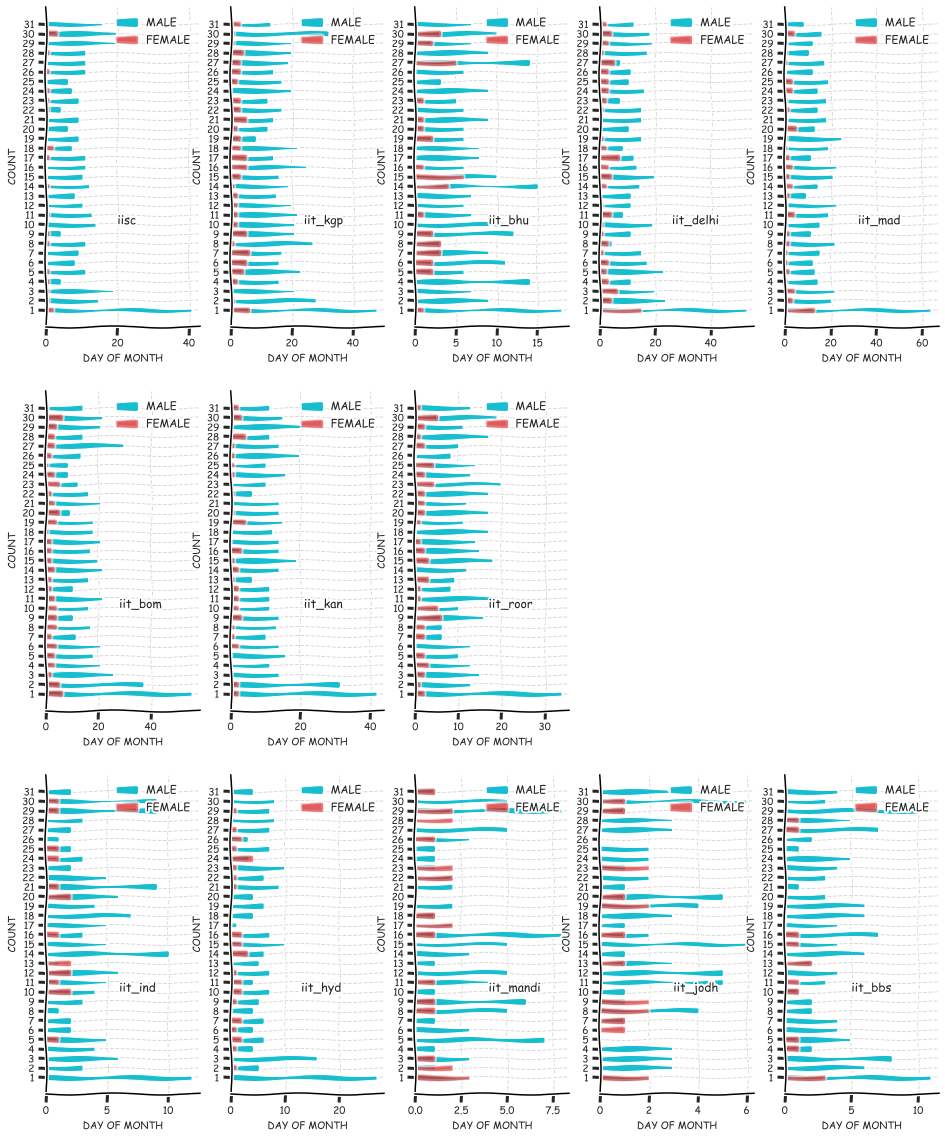

In [11]:
#collapse
# day of recruitment
x_grid = np.arange(min(df['joining_day']),max(df['joining_day'])+1)
y_grid = np.arange(0,len(institutes))

X, Y = np.meshgrid(x_grid, y_grid)
Z_m = np.zeros(X.shape)
Z_f = np.zeros(X.shape)

for i in range(len(institutes)):
    for j in range(len(x_grid)):
        Z_m[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_day']==x_grid[j])) & ((df['gender']=='Male'))])
        Z_f[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_day']==x_grid[j])) & ((df['gender']=='Female'))])        

with plt.xkcd():
    fig = plt.figure(figsize=[16,20])
    for i in range(Z_m.shape[0]):
        FS = 10
        clr = 'tab:cyan'
        if i>7:
            ax = plt.subplot(3,5,i+3)
        else:
            ax = plt.subplot(3,5,i+1)

        ax.barh(x_grid,Z_m[i,:],color=clr,alpha=1,height=0.5,label='MALE')
        ax.barh(x_grid,Z_f[i,:],color='tab:red',alpha=0.5,height=0.5,label='FEMALE')
        plt.legend(frameon=False,loc='upper right')
        plt.yticks(x_grid,x_grid,rotation=0, fontsize=FS)
        ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
        plt.ylabel('COUNT',fontsize=FS)
        plt.xlabel('DAY OF MONTH',fontsize=FS)

        plt.xticks(fontsize=FS)
        plt.yticks(fontsize=FS)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)  
        ax.text(max(Z_m[i,:])//2,10,institutes[i],fontsize=FS+2)
    plt.show() 

## Months (into job) versus Faculty Designation ...

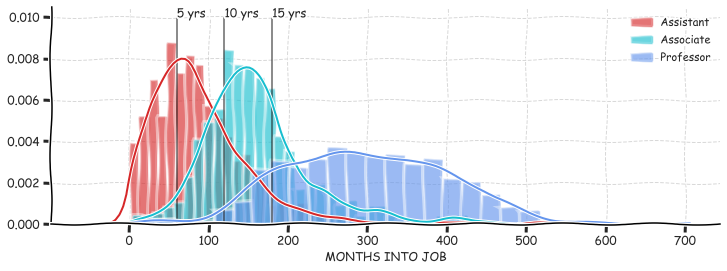

In [12]:
#collapse
vals = []
vals.append(df['months'].values)
vals.append(df['designation'].values)

with plt.xkcd():
    fig = plt.subplots(figsize=[12,4])
    ax = plt.subplot(1,1,1)
    FS = 12
    clr = 'cornflowerblue'
    sns.distplot(df[df['designation']=='Assistant']['months'],label='Assistant'
                 ,color='tab:red')
    sns.distplot(df[df['designation']=='Associate']['months'],label='Associate'
                 ,color='tab:cyan')
    sns.distplot(df[df['designation']=='Professor']['months'],label='Professor'
                 ,color='cornflowerblue')
    ax.legend(frameon=False, loc='upper right')
    ax.vlines(5*12,0,.01,color='k',alpha=0.5)
    ax.vlines(10*12,0,.01,color='k',alpha=0.5)
    ax.vlines(15*12,0,.01,color='k',alpha=0.5)
    ax.text(5*12,0.01,'5 yrs', fontsize=FS)
    ax.text(10*12,0.01,'10 yrs', fontsize=FS)
    ax.text(15*12,0.01,'15 yrs', fontsize=FS)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.xlabel('MONTHS INTO JOB',fontsize=FS)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    plt.show()


## Assitant Professor age during recruitment ...

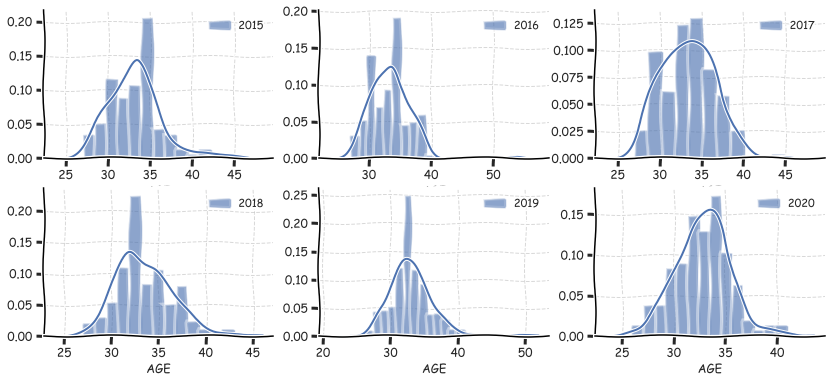

In [13]:
#collapse
vals = []
years = []
cnt = 5
for i in range(2015,2021):
    years.append(i)
    vals.append(df[(df['joining_year']==i) & (df['designation']=='Assistant')]['age'].values-cnt)
    cnt = cnt-1

with plt.xkcd():
    fig = plt.subplots(figsize=[14,6])
    FS = 12
    clr = 'cornflowerblue'
    for i in range(len(years)):
        ax = plt.subplot(2,3,i+1)
        sns.distplot(vals[i],label=str(years[i]))
        ax.legend(frameon=False, loc='upper right')
        ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
        plt.xlabel('AGE',fontsize=FS)
        plt.xticks(fontsize=FS)
        plt.yticks(fontsize=FS)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)  
    plt.show()



## What do we interpret ....I will update soon

If you have suggestion or interpretations ....feel free to comment below or email me.
